In [28]:
import os


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error , r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [30]:
store_sales = pd.read_csv("train.csv")
store_sales.head(10)

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
5,2013-01-06,1,1,12
6,2013-01-07,1,1,10
7,2013-01-08,1,1,9
8,2013-01-09,1,1,12
9,2013-01-10,1,1,9


In [31]:
store_sales = store_sales.drop(['store', 'item'],axis=1)
store_sales.head(10)

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
5,2013-01-06,12
6,2013-01-07,10
7,2013-01-08,9
8,2013-01-09,12
9,2013-01-10,9


In [32]:
store_sales['date']= pd.to_datetime(store_sales['date'])

In [33]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [34]:
store_sales['date'] = store_sales['date'].dt.to_period('M')
monthly_sales = store_sales.groupby('date').sum().reset_index()
monthly_sales['date'] = monthly_sales['date'].dt.to_timestamp()
monthly_sales.head(10)

,date,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


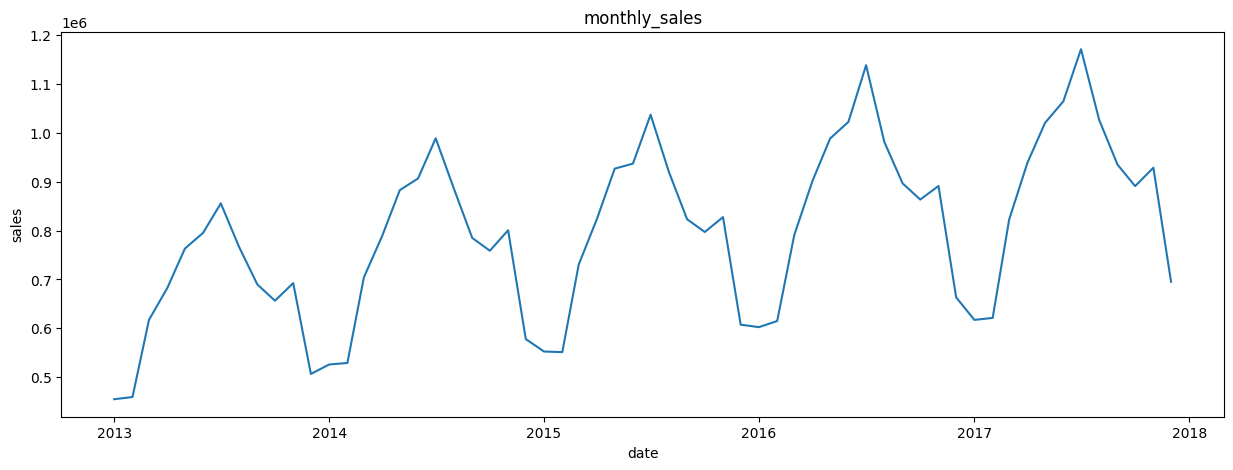

In [35]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("monthly_sales")
plt.show()

In [36]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()
monthly_sales = monthly_sales.dropna()
monthly_sales.head(12)


,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


In [37]:
supervised_data = monthly_sales.drop(['date','sales'],axis=1)


In [38]:
for i in range(1,13):
  col_name = 'month_'+str(i)
  supervised_data[col_name] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


In [39]:
train_data = supervised_data[:-12]
test_data = supervised_data[-12:]
print("train_data shape", train_data.shape)
print("test_data shape", test_data.shape)



train_data shape (35, 13)
test_data shape (12, 13)


In [40]:
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [41]:
x_train, y_train = train_data[:,1:], train_data[:,0:1]
x_test, y_test = test_data[:,1:], test_data[:,0:1]
y_train = y_train.ravel()
y_test = y_test.ravel()
print("x_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print("x_test shape", x_test.shape)
print("y_test shape", y_test.shape)

x_train shape (35, 12)
y_train shape (35,)
x_test shape (12, 12)
y_test shape (12,)


In [42]:
sales_dates = monthly_sales['date'][-12:].reset_index(drop=True)
predict_df = pd.DataFrame(sales_dates)


In [43]:
act_sales = monthly_sales['sales'][-13:].to_list()
print(act_sales)

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


In [44]:
lr_model = LinearRegression()
lr_model.fit(x_train,y_train)
lr_pred = lr_model.predict(x_test)

In [45]:
lr_pred = lr_pred.reshape(-1,1)
lr_pred_test_set = np.concatenate([lr_pred, x_test,],axis=1)
lr_pred_test_set = scaler.inverse_transform(lr_pred_test_set)

In [46]:
result_list = []
for index in range(len(lr_pred_test_set)):
  result_list.append(lr_pred_test_set[index][0] + act_sales[index] )
lr_pred_Series = pd.Series(result_list, name="linear prediction")
predict_df = predict_df.merge(lr_pred_Series,left_index = True, right_index = True)


In [47]:
lr_mse = np.sqrt(mean_squared_error(predict_df['linear prediction'],monthly_sales['sales'][-12:]))
lr_mae = mean_absolute_error(predict_df['linear prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['linear prediction'],monthly_sales['sales'][-12:])
print("lr_mse",lr_mse)
print("lr_mae",lr_mae)
print("lr_r2",lr_r2)

lr_mse 16221.272385416869
lr_mae 12433.184266490736
lr_r2 0.9906152516380969


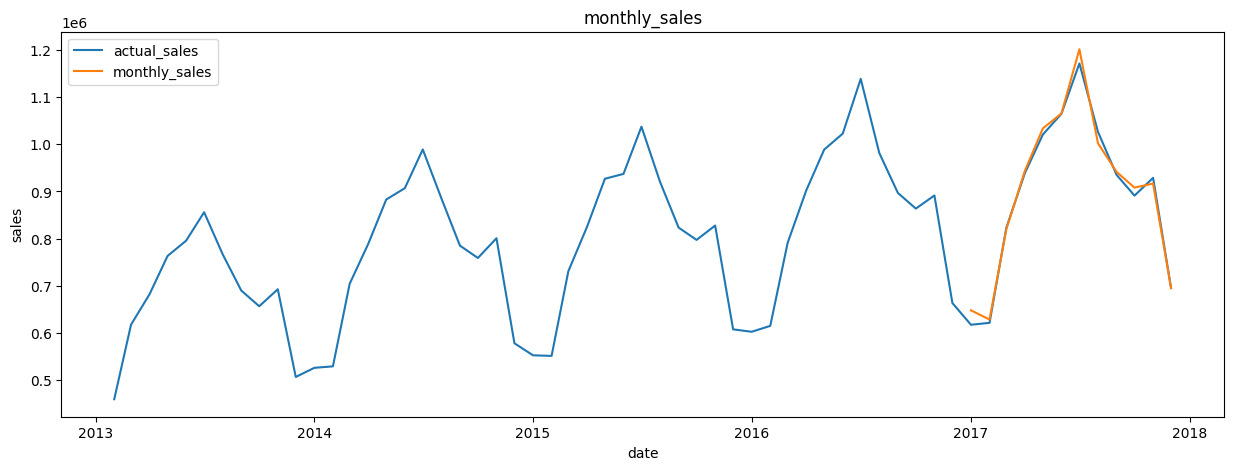

In [48]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.plot(predict_df['date'],predict_df['linear prediction'])
plt.xlabel("date")
plt.ylabel("sales")
plt.title("monthly_sales")
plt.legend(["actual_sales","monthly_sales"])
plt.show()